# GRACE & GRACE FO downscaling project


<font color='Cyan'>This s a notebok for downscaling GRACE data using ERA5. Downscaling is done using XGBoost or Random Forest models.</font>


<font size="2">To run this notebook, first install the required packages as described in the README_notebook.md file. It is recomended to create a virtual environment and install the packages there. 
It is also recomended to create a similar folder structure as the one in the README_notebook.md file.</font>

<font size="2">Download ERA5 data. To do so follow first instructions from https://confluence.ecmwf.int/display/CKB/How+to+install+and+use+CDS+API+on+Windows. If you are using a different OS, follow instructions from https://confluence.ecmwf.int/display/CKB/How+to+install+and+use+CDS+API+on+Linux+or+Mac. You can see details on the ERA5 variables at https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download. Please have in mind that if you want to use a different variable, you need to modify the backend_notebook.ipynb file.</font>

# <font size="4"> Import dependencies </font>

In [2]:
import cdsapi
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import cartopy.crs as ccrs 
import cartopy.feature as cfeature 
import xgboost as xgb
import joblib
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os
from colorama import Fore
import seaborn as sns

# <font size="4"> ERA5 Data Download </font>

In [15]:
#Download ERA5 data from the Copernicus Data Store API
import cdsapi

dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "2m_temperature",
        "total_precipitation",
        "evaporation",
        "potential_evaporation",
        "sub_surface_runoff",
        "surface_runoff",
        "soil_type",
        "volumetric_soil_water_layer_1",
        "volumetric_soil_water_layer_2",
        "volumetric_soil_water_layer_3",
        "volumetric_soil_water_layer_4",
        "leaf_area_index_high_vegetation",
        "leaf_area_index_low_vegetation"
    ],
    "year": [
        "2002", "2003", "2004",
        "2005", "2006", "2007",
        "2008", "2009", "2010",
        "2011", "2012", "2013",
        "2014", "2015", "2016",
        "2017", "2018", "2019",
        "2020", "2021", "2022",
        "2023", "2024", "2025"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2025-12-22 17:21:28,657 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


KeyboardInterrupt: 

# <font size="4"> Import datasets</font>

In [3]:
#Import datasets
CSR_path  = "../data/CSR_GRACE_GRACE-FO_RL0603_Mascons_all-corrections.nc"
ERA_path1 = "../data/data_stream-moda_stepType-avgad.nc"
ERA_path2 = "../data/data_stream-moda_stepType-avgua.nc"

In [4]:
# read-print dataset
ds = xr.open_dataset(CSR_path)
ds_era1 = xr.open_dataset(ERA_path1)
ds_era2 = xr.open_dataset(ERA_path2)
# print(ds.head())
# print(ds_era1.head())
# print(ds_era2.head())

# <font size="4"> Data Slicing to Region of Interest </font>

In [5]:
# Data slicing to Area of Interest

print("Input Area of Interest extend latΕ[-90,90], lonΕ[-180,180]")
try:
    lat_min = float(input("Latitude Min : "))
    lat_max = float(input("Latitude Max : "))
    lon_min = float(input("Longitude Min : "))
    lon_max = float(input("Longitude Max : "))
except ValueError:
    print("Wrong input! Please insert a number!")
print(f"\nArea of Interest: Lat[{lat_min}, {lat_max}], Lon[{lon_min}, {lon_max}]")

# Slice function
def slice_nc(ds, ds_name):
    print(f"\nSlicing {ds_name}")

    possible_lat_names = ['lat', 'latitude']
    possible_lon_names = ['lon', 'longitude']
    
    lat_name = None
    lon_name = None

    print("Checking for possible lat/lon names ")
    for name in ds.coords:
        # Checking with .lower() for possible lat/lon names
        if name.lower() in possible_lat_names:
            lat_name = name
        elif name.lower() in possible_lon_names:
            lon_name = name
    
    if not lat_name or not lon_name:
        raise ValueError(f" ERROR: There are no lat/lon columns in {ds_name}")

    # Converting Longitude (0-360 -> -180,180) ---
    if ds[lon_name].max() > 180:
        print(" Converting Longitude in -180,180")
        ds = ds.assign_coords({lon_name: (((ds[lon_name] + 180) % 360) - 180)})
    ds = ds.sortby(lon_name)

    # Check convertion
    lat_values = ds[lat_name].values  
    # Sorting
    if lat_values[0] > lat_values[-1]: 
        lat_slice = slice(lat_max, lat_min)
    else:
        lat_slice = slice(lat_min, lat_max)

    # Final slice to Area of Interest
    ds_sliced = ds.sel({
        lat_name: lat_slice, 
        lon_name: slice(lon_min, lon_max)
    })
    return ds_sliced

ds_grace_sliced = slice_nc(ds, "GRACE")
ds_era1_sliced = slice_nc(ds_era1, "ERA5_1")
ds_era2_sliced = slice_nc(ds_era2,"ERA5_2")
print(f"\nCreated a data slice to the area of interest: Lat[{lat_min}, {lat_max}], Lon[{lon_min}, {lon_max}] ")

Input Area of Interest extend latΕ[-90,90], lonΕ[-180,180]

Area of Interest: Lat[-17.0, 5.0], Lon[-80.0, -50.0]

Slicing GRACE
Checking for possible lat/lon names 
 Converting Longitude in -180,180

Slicing ERA5_1
Checking for possible lat/lon names 
 Converting Longitude in -180,180

Slicing ERA5_2
Checking for possible lat/lon names 
 Converting Longitude in -180,180

Created a data slice to the area of interest: Lat[-17.0, 5.0], Lon[-80.0, -50.0] 


# <font size="4"> Create year, month columns for data alignment </font>

In [6]:
# Fixing the time variable in GRACE data: exporting year and month from timestamp
ds = ds_grace_sliced
ds["time"] = pd.to_datetime(
    ds.time.values, origin="2002-01-01", unit="D"
)

# Drop time_bounds column, if it exists
ds = ds.drop_vars("time_bounds", errors="ignore")
# print(ds)

# Convert xarray dataset to pandas dataframe
ds = ds_grace_sliced
grace_df = ds.to_dataframe().reset_index()
# print(grace_df.head())

# Add year and month columns to the dataframe
grace_df["year"] = grace_df["time"].dt.year
grace_df["month"] = grace_df["time"].dt.month
print(grace_df) 

                       time  timebound     lat     lon  time_bounds  \
0       2002-04-18 00:00:00          0 -16.875 -79.875         94.0   
1       2002-04-18 00:00:00          0 -16.875 -79.625         94.0   
2       2002-04-18 00:00:00          0 -16.875 -79.375         94.0   
3       2002-04-18 00:00:00          0 -16.875 -79.125         94.0   
4       2002-04-18 00:00:00          0 -16.875 -78.875         94.0   
...                     ...        ...     ...     ...          ...   
5237755 2025-08-16 12:00:00          1   4.875 -51.125       8644.0   
5237756 2025-08-16 12:00:00          1   4.875 -50.875       8644.0   
5237757 2025-08-16 12:00:00          1   4.875 -50.625       8644.0   
5237758 2025-08-16 12:00:00          1   4.875 -50.375       8644.0   
5237759 2025-08-16 12:00:00          1   4.875 -50.125       8644.0   

         lwe_thickness  year  month  
0            -0.473648  2002      4  
1            -0.473648  2002      4  
2            -0.141746  2002     

In [7]:
# Convert ERA5 data to DataFrames
ds_era1 = ds_era1_sliced
ds_era2 = ds_era2_sliced
era5_df1 = ds_era1.to_dataframe().reset_index()
era5_df2 = ds_era2.to_dataframe().reset_index()

# Fix the time variable in ERA5 data: exporting year and month from timestamp
era5_df1["year"] = era5_df1["valid_time"].dt.year
era5_df1["month"] = era5_df1["valid_time"].dt.month
era5_df2["year"] = era5_df2["valid_time"].dt.year
era5_df2["month"] = era5_df2["valid_time"].dt.month

# Rename longitude and latitude columns for data alignment
era5_df1 = era5_df1.rename(columns={"longitude": "lon", "latitude": "lat"})
era5_df2 = era5_df2.rename(columns={"longitude": "lon", "latitude": "lat"})

# print(era5_df1.head())
# print(era5_df2.head())

# <font size="4"> Merge ERA5 and GRACE datasets => Create training dataset </font>

In [8]:
# Merge the ERA5 dataframes on lon, lat, year, month
era5_df = pd.merge(
    era5_df1,
    era5_df2,
    on=[ "lon", "lat", "year", "month"],
    how="inner"
)
era5_df_merged=era5_df.drop(columns=['valid_time_y', 'valid_time_x', 'number_x', 'number_y', 'expver_x', 'expver_y'])
print(era5_df_merged.head())

   lat    lon        tp         e           pev  ssro  sro  year  month  \
0  5.0 -80.00  0.008549 -0.002826  7.450581e-08   0.0  0.0  2002      1   
1  5.0 -79.75  0.010048 -0.002742  7.450581e-08   0.0  0.0  2002      1   
2  5.0 -79.50  0.011562 -0.002648  7.450581e-08   0.0  0.0  2002      1   
3  5.0 -79.25  0.012827 -0.002535  7.450581e-08   0.0  0.0  2002      1   
4  5.0 -79.00  0.014244 -0.002271  7.450581e-08   0.0  0.0  2002      1   

          t2m  slt     swvl1     swvl2     swvl3         swvl4  lai_hv  lai_lv  
0  299.309570  0.0  0.000004  0.000003  0.000001 -3.557767e-26     0.0     0.0  
1  299.254883  0.0  0.000004  0.000003  0.000001 -3.557767e-26     0.0     0.0  
2  299.211914  0.0  0.000004  0.000003  0.000001 -3.557767e-26     0.0     0.0  
3  299.202148  0.0  0.000004  0.000003  0.000001 -3.557767e-26     0.0     0.0  
4  299.198242  0.0  0.000004  0.000003  0.000001 -3.557767e-26     0.0     0.0  


In [9]:
# Compute GRACE resolution

g_lats = np.sort(grace_df["lat"].unique()) 
g_lons = np.sort(grace_df["lon"].unique())

dlat = np.diff(g_lats)
dlon = np.diff(g_lons)

step_lat = dlat[dlat > 0].min()
step_lon = dlon[dlon > 0].min()

step = float(min(step_lat, step_lon))
print("GRACE resolution ~", step, "degrees")

GRACE resolution ~ 0.25 degrees


In [10]:
# Regrid the merged ERA5 dataframe to match the grace_df grid (use step variable from the cell above)

grace_df["lat_r"] = (grace_df["lat"] / step).round() * step
grace_df["lon_r"] = (grace_df["lon"] / step).round() * step

era5_df_merged2=era5_df_merged.copy()
era5_df_merged2["lat_r"] = (era5_df_merged2["lat"] / step).round() * step
era5_df_merged2["lon_r"] = (era5_df_merged2["lon"] / step).round() * step
print(grace_df.head())
print(era5_df_merged2.head())

        time  timebound     lat     lon  time_bounds  lwe_thickness  year  \
0 2002-04-18          0 -16.875 -79.875         94.0      -0.473648  2002   
1 2002-04-18          0 -16.875 -79.625         94.0      -0.473648  2002   
2 2002-04-18          0 -16.875 -79.375         94.0      -0.141746  2002   
3 2002-04-18          0 -16.875 -79.125         94.0      -0.141746  2002   
4 2002-04-18          0 -16.875 -78.875         94.0      -0.141746  2002   

   month  lat_r  lon_r  
0      4  -17.0  -80.0  
1      4  -17.0  -79.5  
2      4  -17.0  -79.5  
3      4  -17.0  -79.0  
4      4  -17.0  -79.0  
   lat    lon        tp         e           pev  ssro  sro  year  month  \
0  5.0 -80.00  0.008549 -0.002826  7.450581e-08   0.0  0.0  2002      1   
1  5.0 -79.75  0.010048 -0.002742  7.450581e-08   0.0  0.0  2002      1   
2  5.0 -79.50  0.011562 -0.002648  7.450581e-08   0.0  0.0  2002      1   
3  5.0 -79.25  0.012827 -0.002535  7.450581e-08   0.0  0.0  2002      1   
4  5.0 -79.0

In [11]:
# Final merge of GRACE and ERA5 datasets
# Merged dataframe is going to be used for training the model

merged = pd.merge(
    grace_df,
    era5_df_merged2,
    on=["year", "month", "lat_r", "lon_r"],
    how="inner",
    suffixes=("_grace", "_era")
)
#print(merged.head())

# Remove rows with year 2025 and above. Training is going to be done up to 2024. 
# 2025 and on is going to be used for testing

merged= merged[merged['year'] <= 2024]
print(f"Most recent year in training dataset: {merged['year'].max()}")

data_out = ['time','lat_r','lat_era','lon_r','lon_era']
merged = merged.drop(columns = data_out, errors='ignore')

print(merged.tail())

Most recent year in training dataset: 2024
         timebound  lat_grace  lon_grace  time_bounds  lwe_thickness  year  \
5068795          1      4.875    -51.125       8401.0       0.516883  2024   
5068796          1      4.875    -50.875       8401.0      -0.308139  2024   
5068797          1      4.875    -50.625       8401.0      -0.308139  2024   
5068798          1      4.875    -50.375       8401.0      -0.308139  2024   
5068799          1      4.875    -50.125       8401.0       0.947064  2024   

         month        tp         e           pev  ssro  sro         t2m  slt  \
5068795     12  0.006504 -0.004061  1.043081e-07   0.0  0.0  299.793457  0.0   
5068796     12  0.006504 -0.004061  1.043081e-07   0.0  0.0  299.793457  0.0   
5068797     12  0.006441 -0.004221  1.043081e-07   0.0  0.0  299.838379  0.0   
5068798     12  0.006441 -0.004221  1.043081e-07   0.0  0.0  299.838379  0.0   
5068799     12  0.007189 -0.004519  1.043081e-07   0.0  0.0  299.891113  0.0   

       

# <font size="4"> Choose model, Train the ERA5 data on GRACE data </font>

In [12]:
# Choose the model
print("Choose the model you want to use: (XGBoost/RF)")
try:
    model_used = (input("Choose ML model (XGBoost/RF): "))
except ValueError:
    print("Error! Please enter 'XGBoost' or 'RF'.")
print(f"The prediction will be made with the model {model_used}")

# Drop NaN values
df_clean = merged.dropna()
y = df_clean["lwe_thickness"]

if model_used == "XGBoost":
    columns_to_select = ['tp', 'sro', 'ssro', 'e', 'swvl1', 'swvl2', 'swvl3', 'swvl4','pev','t2m','slt','lai_hv', 'lai_lv']
    x = df_clean.loc[:, columns_to_select]
    print(f"Features included in training: {x.columns.to_list()}")
    model = xgb.XGBRegressor(objective="reg:squarederror",n_estimators=50, random_state=42, n_jobs=-1)

elif model_used == "RF":
    columns_to_select = ['tp', 'sro', 'ssro', 'e', 'swvl1', 'swvl2', 'swvl3', 'swvl4','pev','t2m','slt','lai_hv', 'lai_lv']
    x = df_clean.loc[:, columns_to_select]
    print(f"Features included in training: {x.columns.to_list()}")
    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
else:
    print("Invalid model input!")
    print("Please enter 'XGBoost' or 'RF'.")
# Choose the number of features you want to select for the RFE
print("Choose the number of features you want to select")
try: 
    n_features_to_select = int(input("Insert the number of features you want to select : ")) 
    print(f"The RFE will be performed with: {n_features_to_select} features")
except ValueError:
    print("Invalid input!")
    sys.exit()

# RFE Classification
rfe = RFE(estimator=model, n_features_to_select= n_features_to_select) 

rfe.fit(x, y)

# Print selected features from RFE
selected_features = x.columns[rfe.support_].tolist()

print("\n RFE Results!")
print(f" Τα {n_features_to_select} Best Features are:")
print(selected_features)

Choose the model you want to use: (XGBoost/RF)
The prediction will be made with the model XGBoost
Features included in training: ['tp', 'sro', 'ssro', 'e', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 'pev', 't2m', 'slt', 'lai_hv', 'lai_lv']
Choose the number of features you want to select
The RFE will be performed with: 5 features

 RFE Results!
 Τα 5 Best Features are:
['tp', 'ssro', 'swvl4', 't2m', 'slt']


# <font size="4"> RFE ranking graph </font>

Map saved to ../results/RFE_ranking_5_features.jpg


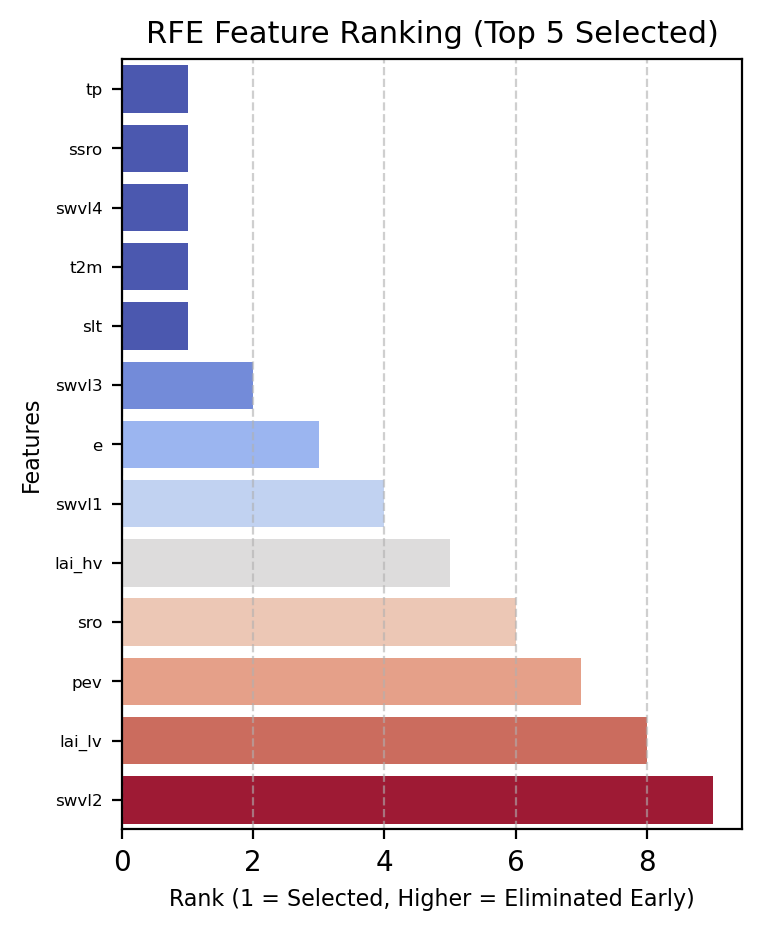

In [23]:
# Dynamic title output save without overwrtie
output_jpg_RFE = f"../results/RFE_ranking_{rfe.n_features_}_features.jpg"

# Solving overwrite output problem 
i=1
while os.path.exists(output_jpg_RFE):
    output_jpg_RFE = f"../results/RFE_ranking_{rfe.n_features_}_features_{i}.jpg"
    i=i+1
else:
    print(f"Map saved to {output_jpg_RFE}")

# Creating pandas df
df_ranking = pd.DataFrame()
# Creating column "Feature" in order to save the rfe feature names participating 
df_ranking["Feature"] = x.columns
# Creating column "Rank" in order to save the rfe feature ranking
df_ranking["Rank"] = rfe.ranking_ 
# Sorting df_ranking based on column "Rank", in ascending order (True)
df_ranking = df_ranking.sort_values(by=['Rank'], ascending=True)
#print(df_ranking)

# Creating figure
plt.figure(figsize=(4, 5), dpi=200) 
# hue = controls the colour by grouping the input data
# creating the barplot graph
sns.barplot(data=df_ranking, x="Rank", y="Feature", hue="Rank",palette="coolwarm", legend=False)

#Formatting
plt.title(f"RFE Feature Ranking (Top {rfe.n_features_} Selected)", fontsize=11)
plt.xlabel("Rank (1 = Selected, Higher = Eliminated Early)", fontsize=8)
plt.ylabel("Features", fontsize=8)
plt.grid(axis="x", linestyle="--", alpha=0.6)
#Changing feature fontsize
plt.yticks(fontsize=6)
# Show the plot

plt.savefig(output_jpg_RFE)
plt.show()

In [ ]:
# Model training and export
# Create array with selected features
x_final = x[selected_features]
print(f"Training will use: \n {x_final.head(1)}")
target = "lwe_thickness"
extra_features = ["year", "month", "lon_grace", "lat_grace"]
base_features = list(x_final.columns)
# Final feature list
features = base_features + extra_features
features = [col for col in features if col != target]
# Define X and y
X = merged[features]
y = merged[target]

# Split into training and validation datasets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    x_final, y,
    test_size=0.2,
    random_state=42
)

if model_used == "XGBoost":
    print("  XGBoost Tuning...")
    param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 0.5, 1.0]
    }

    final_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    tuner = RandomizedSearchCV(
        final_model,
        param_distributions=param_grid,
        n_iter=20,                     
        cv=kf,
        scoring="neg_mean_absolute_error",
        n_jobs=1,                      
        verbose=1,
        random_state=42
    )

    tuner.fit(X_train, y_train)
    best_params = tuner.best_params_
    print(" Best XGBoost Parameters:", best_params)

    best_model = xgb.XGBRegressor(
        **best_params,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

elif model_used == "RF":
    param_grid = {
        'n_estimators': [100, 200, 300],        
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }

    final_model = RandomForestRegressor(random_state=42, n_jobs=-1)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)  # 3-FOLD → faster
    tuner = RandomizedSearchCV(
        final_model,
        param_distributions=param_grid,
        n_iter=10,                     
        cv=kf,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    # Fit tuner
    tuner.fit(X_train, y_train)
    best_params = tuner.best_params_
    print("Best Parameters:", best_params)

    # Train final model with best params
    best_model = RandomForestRegressor(
        **best_params,
        random_state=42,
        n_jobs=-1
    )
    best_model.fit(X_train, y_train)

    # Predict
    y_pred = best_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Root Mean Squared Error (σε cm)
r2 = r2_score(y_test, y_pred) # R-squared (max=1.0)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_test - y_pred)

print(f" R² Score : {r2:.4f}  (Excellent = 1.0)")
print(f" RMSE :      {rmse:.4f} cm")
print(f" ΜΑΕ : {mae:.4f} ")
print(f" BIAS :   {bias:.4f} cm")

# Ask user for model name
model_name = input("Enter model filename (without extension): ").strip()
if not model_name:
    model_name = "model"  # default name

models_dir = Path.cwd().parent / "models"
models_dir.mkdir(exist_ok=True)  # Create models folder if it doesn't exist

model_path = str(models_dir / f"{model_name}.pkl")
print(f"Saving model to: {model_path}")

joblib.dump(best_model, model_path)
print(f"✓ Model saved successfully!")


Training will use: 
       swvl2    swvl3     swvl4       pev         t2m
0  0.400846  0.38131  0.334152 -0.003906  294.242798
  XGBoost Tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
 Best XGBoost Parameters: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
 R² Score : 0.9703  (Excellent = 1.0)
 RMSE :      4.4760 cm
 ΜΑΕ : 2.0800 
 BIAS :   -0.0365 cm
Saving model to: c:\Users\akara\OneDrive\Desktop\DE_Karachles\test\models\xg_missisipi_5f.pkl
✓ Model saved successfully!


# <font size="4"> Compute training curves RF </font>

Training with:
          tp  ssro         swvl4         t2m  lai_hv
0  0.000439   0.0 -1.102908e-25  295.018188     0.0

Tuning begins (subset)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}

Computing learning curves...
Trees:   10 | Train MAE: 1.9128 | Val MAE: 4.4887
Trees:   25 | Train MAE: 1.6801 | Val MAE: 4.1938
Trees:   40 | Train MAE: 1.6092 | Val MAE: 4.1079
Trees:   55 | Train MAE: 1.5786 | Val MAE: 4.0712
Trees:   71 | Train MAE: 1.5562 | Val MAE: 4.0364
Trees:   86 | Train MAE: 1.5427 | Val MAE: 4.0269
Trees:  101 | Train MAE: 1.5327 | Val MAE: 4.0170
Trees:  116 | Train MAE: 1.5260 | Val MAE: 4.0111
Trees:  132 | Train MAE: 1.5196 | Val MAE: 4.0046
Trees:  147 | Train MAE: 1.5153 | Val MAE: 4.0014
Trees:  162 | Train MAE: 1.5110 | Val MAE: 3.9941
Trees:  177 | Train MAE: 1.5095 | Val MAE: 3.9946
Trees:  193 | Train MAE: 1.5075 

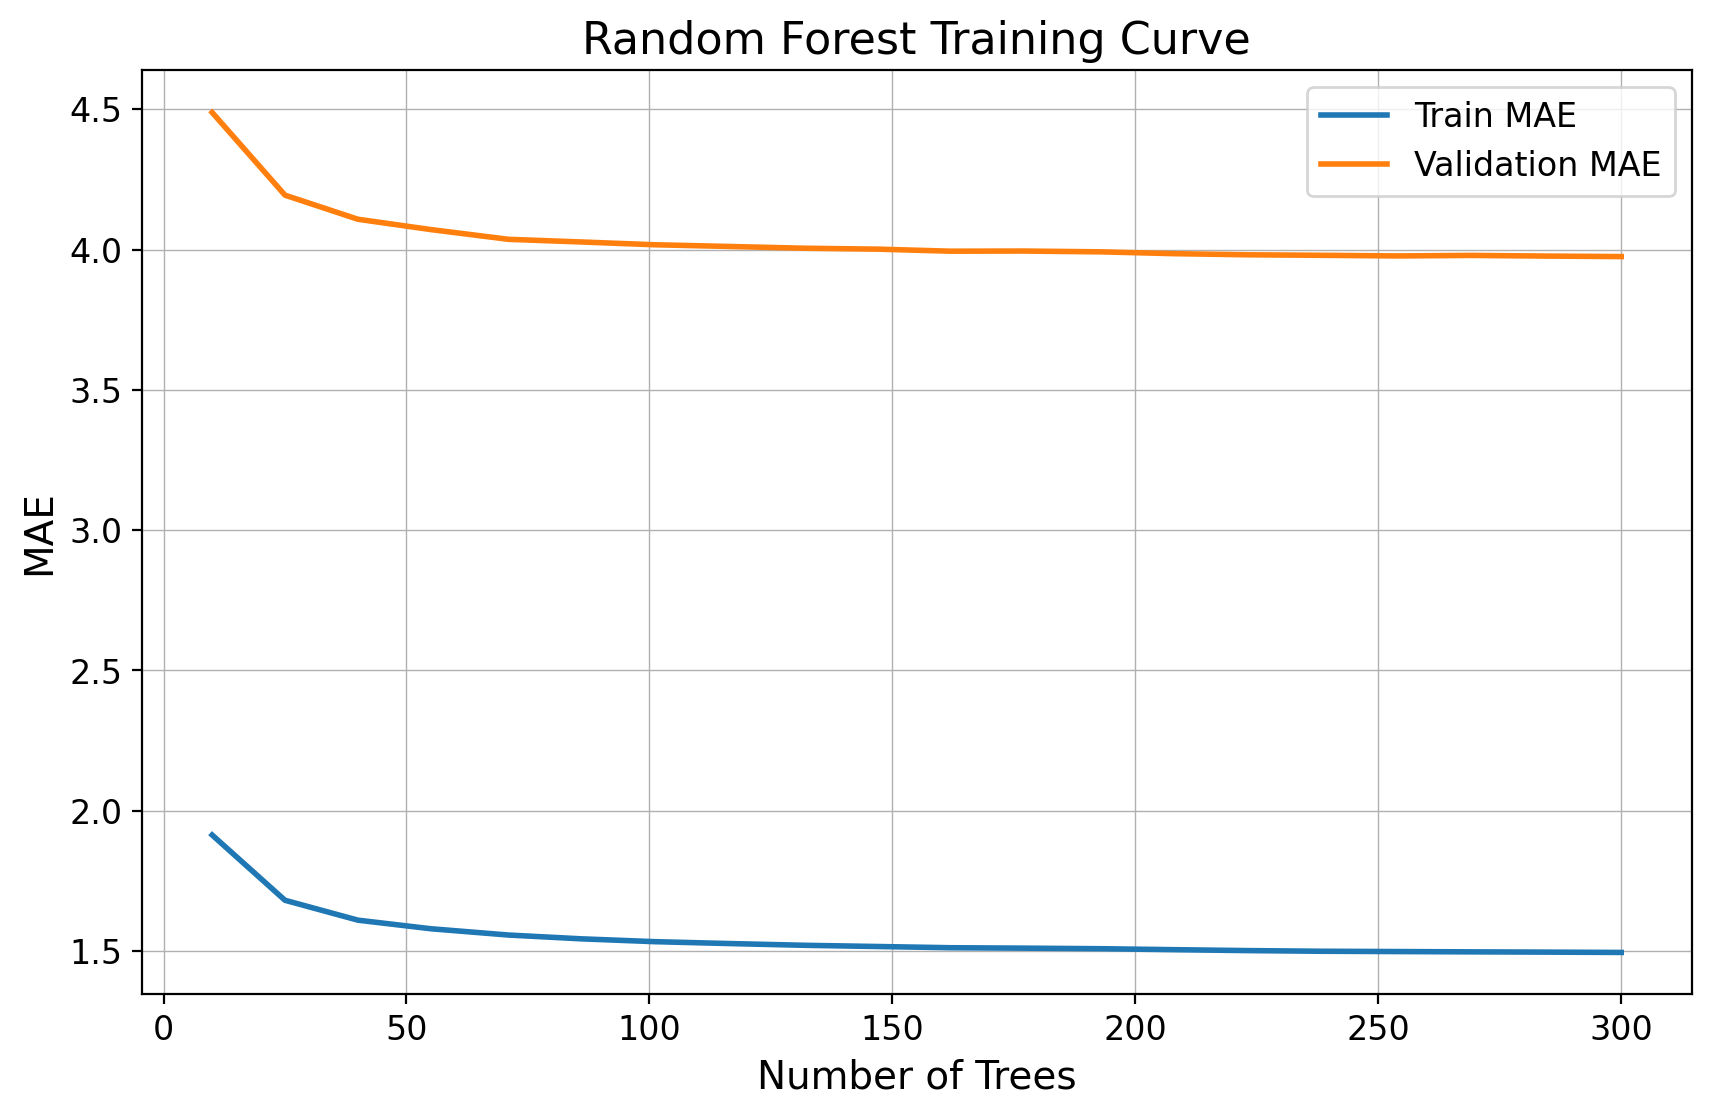


 Training curve saved to: ../results/random_forest_training_curve.png

Εκπαίδευση τελικού μοντέλου στο πλήρες training set...

Αποτελέσματα στο test set:
 R² Score (Ακρίβεια): 0.9971
 RMSE (Σφάλμα):       1.1325 cm
 MAE (Μέσο λάθος):    0.4302
 BIAS (Μεροληψία):    0.0013 cm

 Model saved as: D:/random_forest_model_fast.pkl


In [ ]:
# Compute the training curves graph

x_final = x[selected_features]
print("Training with:\n", x_final.head(1))

target = "lwe_thickness"
extra_features = ["year", "month", "lon_grace", "lat_grace"]

base_features = list(x_final.columns)
features = base_features + extra_features
features = [col for col in features if col != target]

X = merged[features]
y = merged[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Max Data Sample
max_tuning_samples = 100000 #adjust as needed eg 50000

if len(X_train) > max_tuning_samples:
    X_tune = X_train.sample(n=max_tuning_samples, random_state=42)
    y_tune = y_train.loc[X_tune.index]
else:
    X_tune = X_train
    y_tune = y_train

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_tune, y_tune, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

kf = KFold(n_splits=3, shuffle=True, random_state=42) 

tuner = RandomizedSearchCV(
    rf_model,
    param_distributions=param_grid, 
    n_iter=10,   
    scoring='neg_mean_absolute_error',
    cv=kf,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("\nTuning begins (subset)...")
tuner.fit(X_train_sub, y_train_sub) 
best_params = tuner.best_params_ 
print(f"\nBest Parameters: {best_params}")

max_trees = best_params['n_estimators']
curve_steps = np.unique(
    np.linspace(10, max_trees, num=min(max_trees // 10, 20), dtype=int)
)

rf_curves = RandomForestRegressor(
    random_state=42,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    n_estimators=1,
    warm_start=True,
    n_jobs=-1
)

train_mae_list = []
val_mae_list = []
current_trees = 0

print("\nComputing learning curves...")
for n_trees in curve_steps:
    rf_curves.n_estimators = int(n_trees)
    rf_curves.fit(X_train_sub, y_train_sub)

    y_train_pred = rf_curves.predict(X_train_sub)
    y_val_pred = rf_curves.predict(X_val)

    train_mae = mean_absolute_error(y_train_sub, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)

    print(f"Trees: {n_trees:4d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")


plt.figure(figsize=(10, 6), dpi=200)
plt.plot(curve_steps, train_mae_list, label='Train MAE', linewidth=2)
plt.plot(curve_steps, val_mae_list, label='Validation MAE', linewidth=2)
plt.xlabel('Number of Trees', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('Random Forest Training Curve', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linewidth=0.5)
curve_path = "../results/random_forest_training_curve.png"
plt.savefig(curve_path, dpi=200)
plt.show()
print(f"\n Training curve saved to: {curve_path}")

best_rf = RandomForestRegressor(
    random_state=42,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    n_estimators=best_params['n_estimators'],
    n_jobs=-1
)

print("\nTraining final model on the full training set")
best_rf.fit(X_train, y_train)


y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_test - y_pred)

print("\nResults on test set:")
print(f" R² Score : {r2:.4f}")
print(f" RMSE :       {rmse:.4f} cm")
print(f" MAE (Mean Absolute Error) :    {mae:.4f}")
print(f" BIAS :    {bias:.4f} cm")



 # <font size="4"> Compute training curves XGBoost</font>

 Starting XGBoost analysis 
Model training will be performed with features::
          tp  ssro         swvl4         t2m  slt
0  0.000439   0.0 -1.102908e-25  295.018188  0.0
 Χρήση δείγματος 100000 για το Tuning...

 Starting Tuning
Fitting 3 folds for each of 10 candidates, totalling 30 fits

 Best Parameters {'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

Calculating learning curves for XGBoost (for 500 trees)
Trees:   10 | Train MAE: 10.1723 | Val MAE: 10.2836
Trees:   35 | Train MAE: 5.2639 | Val MAE: 5.6263
Trees:   61 | Train MAE: 3.7405 | Val MAE: 4.3000
Trees:   87 | Train MAE: 3.0759 | Val MAE: 3.7844
Trees:  113 | Train MAE: 2.6801 | Val MAE: 3.4978
Trees:  138 | Train MAE: 2.4503 | Val MAE: 3.3473
Trees:  164 | Train MAE: 2.2847 | Val MAE: 3.2578
Trees:  190 | Train MAE: 2.1444 | Val MAE: 3.1830
Trees:  216 | Train MAE: 2.0341 | Val MAE: 3.1333
Trees:  242 | Train MAE: 1.9362 | Val MAE: 3.0890
Trees:  267 | Tra

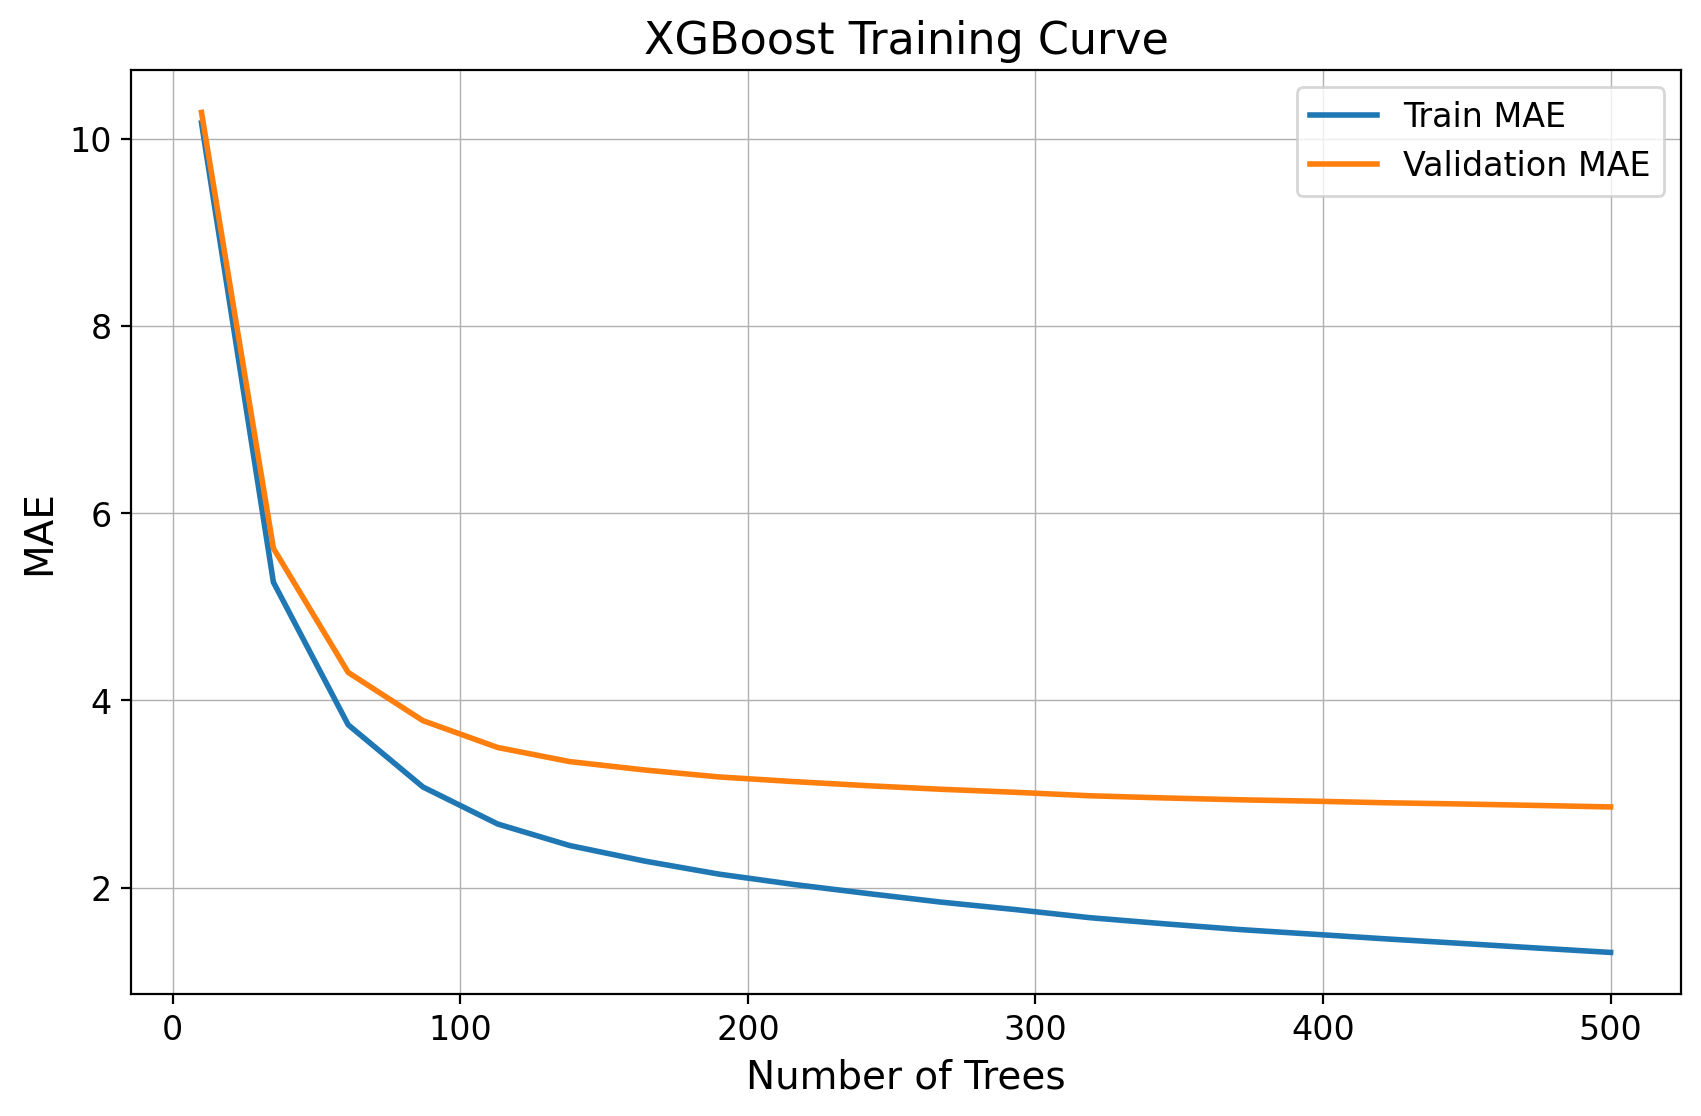

 Training curve saved to : ../results/XGBoost_training_curve.png

 Training final model with 300 trees
------------------------------
 R² Score : 0.9693
 RMSE :       3.6919 cm
 MAE (Mean Absolute Error):    2.3215 cm
 BIAS :    -0.0003 cm
------------------------------


In [17]:
#XGB_learning curve

print(" Starting XGBoost analysis ")
x_final = x[selected_features]
print("Model training will be performed with features::\n", x_final.head(1))

target = "lwe_thickness"
extra_features = ["year", "month", "lon_grace", "lat_grace"]

base_features = list(x_final.columns)
features = base_features + extra_features
features = [col for col in features if col != target]

X = merged[features]
y = merged[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

max_tuning_samples = 100000 

if len(X_train) > max_tuning_samples:
    print(f" Χρήση δείγματος {max_tuning_samples} για το Tuning...")
    X_tune = X_train.sample(n=max_tuning_samples, random_state=42)
    y_tune = y_train.loc[X_tune.index]
else:
    X_tune = X_train
    y_tune = y_train

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_tune, y_tune, test_size=0.2, random_state=42
)

# Tuning 
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=1)

param_grid = {
    'n_estimators': [100, 200, 500], #500
    'max_depth': [10, 15, 6], 
    'colsample_bytree': [0.7, 0.8, 1], #0.7,0.8,1
    'min_child_weight': [1, 3, 5], 
    'learning_rate': [0.01, 0.05, 0.1] #0.01,0.05,0.1
}

kf = KFold(n_splits=3, shuffle=True, random_state=42) #5

tuner = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=10,                      
    scoring='neg_mean_absolute_error', 
    cv=kf,                          
    verbose=1,
    n_jobs=1,                      
    random_state=42
)

print("\n Starting Tuning")
tuner.fit(X_train_sub, y_train_sub)
best_params = tuner.best_params_
print(f"\n Best Parameters {best_params}")

# Using optimal number of trees found by Tuning
max_trees = best_params['n_estimators']
curve_steps = np.unique(
    np.linspace(10, max_trees, num=min(max_trees // 10, 20), dtype=int)
)
# Lists for storing results
train_mae_list = []
val_mae_list = []

print(f"\nCalculating learning curves for XGBoost (for {max_trees} trees)")

for n_trees in curve_steps:
    
    # Create a temporary model for this step
    # We use the best_params except n_estimators (which we set manually here)
    # Filter parameters to remove 'n_estimators'
    params_without_n = {k: v for k, v in best_params.items() if k != 'n_estimators'}
    
    xgb_curves = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,             
        n_estimators=int(n_trees), 
        **params_without_n     
    )
    
    # Train on the subset (sub)
    xgb_curves.fit(X_train_sub, y_train_sub)

    # Predictions
    y_train_pred = xgb_curves.predict(X_train_sub)
    y_val_pred = xgb_curves.predict(X_val)

    # Calculating errors
    train_mae = mean_absolute_error(y_train_sub, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)

    print(f"Trees: {n_trees:4d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")

# plot
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(curve_steps, train_mae_list, label='Train MAE', linewidth=2)
plt.plot(curve_steps, val_mae_list, label='Validation MAE', linewidth=2)
plt.xlabel('Number of Trees', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('XGBoost Training Curve', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linewidth=0.5)


# Saving plot
curve_path = "../results/XGBoost_training_curve.png"
plt.savefig(curve_path, dpi=200)
plt.show()
print(f" Training curve saved to : {curve_path}")

final_n_estimators = 300  

print(f"\n Training final model with {final_n_estimators} trees")

best_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    **{k: v for k, v in best_params.items() if k != 'n_estimators'}, 
    n_estimators=final_n_estimators
)

best_xgb.fit(X_train, y_train)

# Evaluation
y_pred = best_xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_test - y_pred)

print("-" * 30)
print(f" R² Score : {r2:.4f}")
print(f" RMSE :       {rmse:.4f} cm")
print(f" MAE (Mean Absolute Error):    {mae:.4f} cm")
print(f" BIAS :    {bias:.4f} cm")
print("-" * 30)


# <font size="4"> stats </font>

In [ ]:
#Import and select .pkl model
models_dir = "../models/"
print(f"\nScanning directory: {models_dir} ")
try:
    available_models = [f for f in os.listdir(models_dir) if f.endswith(".pkl")]
    if not available_models:
        print(" Error: No .pkl files found in the models directory!")
        sys.exit()

    print(" Available Models:")
    for i, model_file in enumerate(available_models):
        print(f"  [{i+1}] {model_file}")

    try:
        selection = int(input(f"\nSelect Model Number (1-{len(available_models)}): "))
        if 1 <= selection <= len(available_models):
            selected_model_name = available_models[selection - 1]
            full_model_path = os.path.join(models_dir, selected_model_name)
            print(f"  Selected: {selected_model_name}")
        else:
            print(Fore.RED + "  Invalid number selected. Exiting.")
            sys.exit()
    except ValueError:
        print(Fore.RED + "  Invalid input. Please enter a number.")
        sys.exit()
except FileNotFoundError:
    print( Fore.RED + f"  Error: Directory '{models_dir}' not found.")
    sys.exit()

# Load the chosen model
print(" Loading model...")
model = joblib.load(full_model_path)

# Prediction 
input_data = era5_df_merged
try:
    required_features = model.feature_names_in_
except AttributeError:
    print("Using default features")
    required_features = features

missing_feats = [c for c in required_features if c not in input_data.columns]
if missing_feats:
    raise KeyError(f"Missing required features in ERA5 input_data: {missing_feats}")
# X_pred = rfe selection features
X_pred = input_data[required_features]
# Take table input_data create a new column (lwe_pred) and fill it with prediction 
input_data["lwe_pred"] = model.predict(X_pred)

#As we can check from the prints grace_df_2 starts from 04/2002 and input_data from 01/2002
# So we are gonna drop from input_data these 3 months (i suppose)
to_drop = (input_data['year'] == 2002) & (input_data['month'] < 4)

#Keep everything that is NOT (~) in that condition
predicted_data = input_data[~to_drop]
#print(predicted_data.head()) 

#Lets import the raw grace data, which is also a pandas dataframe 
#I have two dataframes with same lat,lon resolution (i will use lat_r,lon_r), i might need to rename _r and drop lat,lon
data_out = ['time','lat','lon']
grace_df_2 = grace_df.drop(columns = data_out, errors='ignore')
#Renaming lat_r, lon_r , in order to be compatible 
grace_df_2 = grace_df_2.rename(columns={"lat_r": "lat", "lon_r": "lon"})
#print(grace_df_2.head())

# For the wanted difference i will first merge the 2 dataframes and then i will create a new column, where i am gonna save the 
# lwe_pred - lwe_thickness result 
merged_df_pred_raw = pd.merge(
    grace_df_2,
    predicted_data,
    on=["year", "month", "lat", "lon"],
    how="inner",
    suffixes=("_grace", "_grace_pred")
)
merged_df_pred_raw["lwe_difference"] = merged_df_pred_raw["lwe_pred"] - merged_df_pred_raw["lwe_thickness"]
print(merged_df_pred_raw.head())

# Stats computed
lwe_diff_min = merged_df_pred_raw["lwe_difference"].min()
lwe_diff_max = merged_df_pred_raw["lwe_difference"].max()
mse_diff = mean_squared_error(merged_df_pred_raw["lwe_thickness"], merged_df_pred_raw["lwe_pred"])
rmse = np.sqrt(mse_diff)
r2 = r2_score(merged_df_pred_raw["lwe_thickness"], merged_df_pred_raw["lwe_pred"])
mae = mean_absolute_error(merged_df_pred_raw["lwe_thickness"], merged_df_pred_raw["lwe_pred"])
bias = np.mean(merged_df_pred_raw["lwe_thickness"] - merged_df_pred_raw["lwe_pred"])

print(f"Minimum Difference : {lwe_diff_min:.4f} cm")
print(f"Maximum Difference : {lwe_diff_max:.4f} cm")
print(f"R² Score (Accuracy): {r2:.4f}")
print(f"RMSE (Root Mean Sq Error): {rmse:.4f} cm")
print(f"MAE (Mean Absolute Error): {mae:.4f} cm")
print(f"Bias (Mean Error): {bias:.4f} cm")
print(f"MSE (Mean Squared Error): {mse_diff:.4f} cm²")




Scanning directory: ../models/ 
 Available Models:
  [1] model.pkl
  [2] random_forest_model_08_2025.pkl
  [3] rf_4_Amazon.pkl
  [4] rf_5features_Amazon.pkl
  [5] rf_6features_Amazon.pkl
  [6] xg5.pkl
  [7] xg_4.pkl
  [8] xg_6.pkl
  [9] xg_missisipi_5f.pkl
  Selected: rf_5features_Amazon.pkl
 Loading model...


c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


   timebound  time_bounds  lwe_thickness  year  month   lat   lon        tp  \
0          0         94.0      -0.473648  2002      4 -17.0 -80.0  0.000439   
1          0         94.0      -0.473648  2002      4 -17.0 -79.5  0.000378   
2          0         94.0      -0.141746  2002      4 -17.0 -79.5  0.000378   
3          0         94.0      -0.141746  2002      4 -17.0 -79.0  0.000334   
4          0         94.0      -0.141746  2002      4 -17.0 -79.0  0.000334   

          e           pev  ...         t2m  slt         swvl1     swvl2  \
0 -0.006054  3.725290e-08  ...  295.018188  0.0 -4.000030e-07  0.000013   
1 -0.005916  3.725290e-08  ...  294.959595  0.0 -4.000030e-07  0.000013   
2 -0.005916  3.725290e-08  ...  294.959595  0.0 -4.000030e-07  0.000013   
3 -0.005648  3.725290e-08  ...  294.924438  0.0 -4.000030e-07  0.000013   
4 -0.005648  3.725290e-08  ...  294.924438  0.0 -4.000030e-07  0.000013   

      swvl3         swvl4  lai_hv  lai_lv  lwe_pred  lwe_difference  
0 -0

# <font size="4"> ploting stats </font>

C:\Users\akara\AppData\Local\Temp\ipykernel_14284\2365705751.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,1].legend()
c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


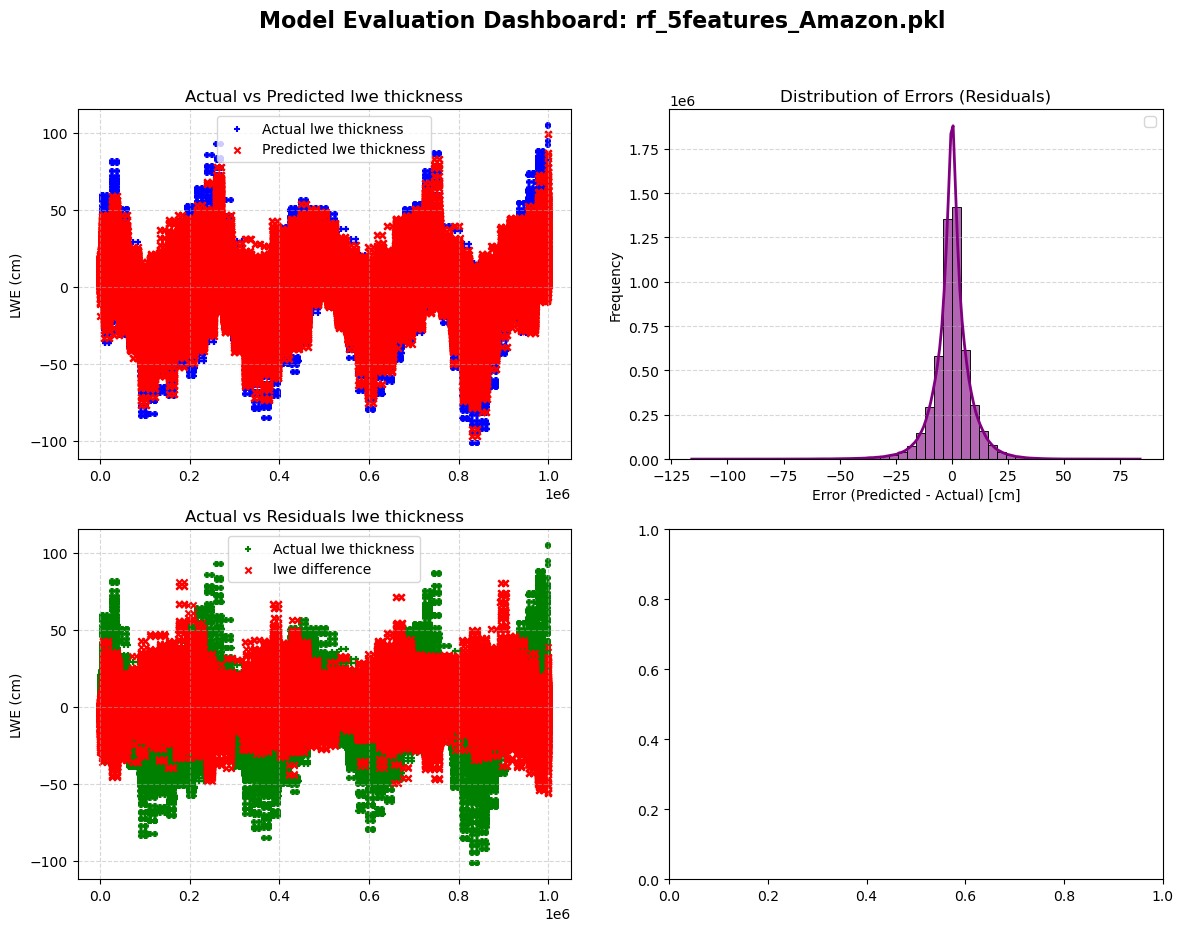

In [24]:
#scatter plot 2 lines for before and after prediction
# histogramm of lwe_difference
#residual plot (diff vs actual)

# We are gonna start by preparing our data for the scatterplot 
#predicted
merged_df_pred_raw["lwe_pred"]
#actual
merged_df_pred_raw["lwe_thickness"]
# in order to save some time we are gonna create the plots using a sample of the data
subset = merged_df_pred_raw.iloc[:1000000]

# subplot 1x3
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)
fig.suptitle(f"Model Evaluation Dashboard: {selected_model_name}", fontsize=16, fontweight='bold')

# Actual vs predicted
axes[0,0].scatter(subset.index, subset["lwe_thickness"], color="blue", marker="+", label="Actual lwe thickness",s=20)
axes[0,0].scatter(subset.index, subset["lwe_pred"], color="red", marker="x", label="Predicted lwe thickness",s=20)
# Formatting
axes[0,0].set_title("Actual vs Predicted lwe thickness")
axes[0,0].set_ylabel("LWE (cm)")
axes[0,0].legend()
axes[0,0].grid(True, linestyle="--", alpha=0.5)

#sns.scatterplot(data=merged_df_pred_raw, x=merged_df_pred_raw["lwe_thickness"], y=merged_df_pred_raw["lwe_pred"],ax=axes[0, 0], 
   # alpha=0.3, color="blue")

#histogramm
sns.histplot(data=merged_df_pred_raw, x="lwe_difference",bins=50, kde=True, line_kws={'color':'black','lw': 2,}, color="purple", ax=axes[0,1], alpha=0.6)
# Formatting
axes[0,1].set_title("Distribution of Errors (Residuals)")
axes[0,1].set_xlabel("Error (Predicted - Actual) [cm]")
axes[0,1].set_ylabel("Frequency")
axes[0,1].legend()
axes[0,1].grid(axis="y", linestyle="--", alpha=0.5)

#residuals
axes[1,0].scatter(subset.index, subset["lwe_thickness"], color="green", marker="+", label="Actual lwe thickness",s=20)
axes[1,0].scatter(subset.index, subset["lwe_difference"], color="red", marker="x", label="lwe difference",s=20)
# Formatting
axes[1,0].set_title("Actual vs Residuals lwe thickness")
axes[1,0].set_ylabel("LWE (cm)")
axes[1,0].legend()
axes[1,0].grid(True, linestyle="--", alpha=0.5)

# Model stats displayed


# <font size="4"> ERA5 evaporation map </font>

In [ ]:
# sos [6] slt [7] swvl1  [8] swvl2 [9] swvl3 [10] swvl4 [11] lai_hv [12] lai_lv plots are created with rendering issues (no rendering) possibly 
# due to their low variance. Try to fix this bug possibly by changing the vmin/vmax values.

#Creating era5 input data for raster plots. These will work as predictors for the trained model.
ds_era5_merged = xr.merge([ds_era1,ds_era2])

feature_list = list(ds_era5_merged.data_vars)
# Creating numeric list of ds_era5_merged features 
print("\n Available Features ")
for i, feature in enumerate(feature_list, 0):
    print(f" [{i}] {feature}")
print("\n Choose a number from the list above to create a raster plot for the corresponding feature.")
# User chooses a number according to list
try:
    era5_feature = int(input("Pick a number from the list: ")) 
except ValueError:
    print(Fore.RED + " Invalid input! Terminating programm.")
    sys.exit() 

#Grab the string name from your list 
#era5_feature is integer
var_to_plot = feature_list[era5_feature]
print(var_to_plot)
# Users input name of basin for title
try:
    basin_name = input("Enter Basin Name for the Title (e.g. Amazon, Lake Victoria): ").strip()
except ValueError:
    print(Fore.RED + " Invalid input! Terminating programm.")
    sys.exit()
# Users input date of map
try:
    map_year = int(input("Enter year: "))
    map_month = int(input("Enter month: "))
except ValueError:
    print(Fore.RED + " Invalid input! Terminating programm.")
    sys.exit() 
# Slice for input year & month
# Specific hour (23:00) required to avoid the midnight reset of features.
data_slice = ds_era5_merged[var_to_plot].sel(valid_time=f'{map_year}-{map_month}-01 23:00', method='nearest')

# I only need month and year
time_str = data_slice.valid_time.dt.strftime("%m-%Y").item()
print(f"Preparing map for '{var_to_plot}' {time_str}")

# Dynamic .jpg title approach
output_jpg_era5 = f"../Maps/ERA5_{basin_name}_{var_to_plot}_{time_str}.jpg"
# Solving overwrite output problem 
i=1
while os.path.exists(output_jpg_era5):
    output_jpg_era5 = f"../Maps/ERA5_{basin_name}_{var_to_plot}_{time_str}_{i}.jpg"
    i=i+1
else:
    print(f"Map saved to {output_jpg_era5}")
    
# Fixing colour range
# Find the value that is smaller than 2% of the data
vmin = data_slice.quantile(0.02).item()
# Find the value that is smaller than 98% of the data
vmax = data_slice.quantile(0.98).item()

plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
plot = data_slice.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Blues",     
    robust=True,
    vmin=vmin, vmax=vmax,    
    cbar_kwargs={     
        "orientation": "vertical",
        "fraction": 0.03,
        "pad": 0.04,
        "label": f"Values ({var_to_plot})"     
    }
)

ax.coastlines(resolution="10m", color="black", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor='gray')

ax.add_feature(cfeature.RIVERS, color='lightblue', linewidth=0.8)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False   
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
ax.set_title(f"{basin_name.upper()} ERA5 {var_to_plot.lower()}  [{time_str}]", fontsize=14, fontweight='bold')

# Remove default xarray labels
ax.set_xlabel("")
ax.set_ylabel("")

plt.savefig(output_jpg_era5, dpi=300, bbox_inches="tight")
print(f" Raster plot saved as: {output_jpg_era5}")
print("Map")
plt.show()

C:\Users\akara\AppData\Local\Temp\ipykernel_29484\3557365159.py:5: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'valid_time' ('valid_time',) The recommendation is to set join explicitly for this case.
  ds_era5_merged = xr.merge([ds_era1,ds_era2])



 Available Features 
 [0] tp
 [1] e
 [2] pev
 [3] ssro
 [4] sro
 [5] t2m
 [6] slt
 [7] swvl1
 [8] swvl2
 [9] swvl3
 [10] swvl4
 [11] lai_hv
 [12] lai_lv

 Choose a number from the list above to create a raster plot for the corresponding feature.


C:\Users\akara\AppData\Local\Temp\ipykernel_29484\3557365159.py:5: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_era5_merged = xr.merge([ds_era1,ds_era2])
C:\Users\akara\AppData\Local\Temp\ipykernel_29484\3557365159.py:5: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_era5_merged = xr.merge([ds_era1,ds_era2])


IndexError: list index out of range

# <font size="4"> Comparison: Actual and Predicted GRACE Maps </font>

In [ ]:
# Subplot raw_predict
models_dir = "../models/"
var_to_plot = "lwe_thickness"

# Select trained Model
print(f"\nScanning directory: {models_dir} ")
try:
    available_models = [f for f in os.listdir(models_dir) if f.endswith(".pkl")]
    if not available_models:
        print(Fore.RED + " Error: No .pkl files found in the models directory!")
        sys.exit()
# comment 
    print(" Available Models:")
    for i, model_file in enumerate(available_models):
        print(f"  [{i+1}] {model_file}")

    try:
        selection = int(input(f"\nSelect Model Number (1-{len(available_models)}): "))
        if 1 <= selection <= len(available_models):
            selected_model_name = available_models[selection - 1]
            full_model_path = os.path.join(models_dir, selected_model_name)
            print(f"  Selected: {selected_model_name}")
        else:
            print(Fore.RED + "  Invalid number selected. Exiting.")
            sys.exit()
    except ValueError:
        print(Fore.RED +"  Invalid input. Please enter a number.")
        sys.exit()

except FileNotFoundError:
    print(Fore.RED + f"  Error: Directory '{models_dir}' not found.")
    sys.exit()

# Load the chosen model
print(" Loading model...")
model = joblib.load(full_model_path)

try:
    basin_name = input("Enter Basin Name for the Title (e.g. Amazon, Lake Victoria): ").strip()
except ValueError:
    print(Fore.RED +" Invalid input! Terminating programm.")
    sys.exit()

# input date
try:
    map_year = int(input("Enter year: "))
    map_month = int(input("Enter month: "))
except ValueError:
    print(Fore.RED +" Invalid input! Terminating programm.")
    sys.exit()

target_ym = f"{map_year}-{map_month:02d}"

# Dynamic .jpg title approach
output_jpg_grace = f"../results/Comparison_GRACE_{basin_name}_{var_to_plot}_{target_ym}.jpg"
# Solving overwrite output problem 
i=1
while os.path.exists(output_jpg_grace):
    output_jpg_grace = f"../results/Comparison_GRACE_{basin_name}_{var_to_plot}_{target_ym}_{i}.jpg"
    i=i+1
else:
    print(f"Map saved to {output_jpg_grace}")
    
# -------------------------
# GRACE raw data (mask by year/month)
# -------------------------
t_index = pd.DatetimeIndex(ds_grace_sliced.time.values)
mask = (t_index.year == map_year) & (t_index.month == map_month)

if not mask.any():
    print(Fore.RED + f" Error: Grace data not found for {target_ym}")
    sys.exit()

# If there are multiple timestamps in the same month, pick the first
idx = int(np.where(mask)[0][0])

data_actual = ds_grace_sliced[var_to_plot].isel(time=idx)
picked_ts = pd.Timestamp(data_actual.time.values)
time_str = picked_ts.strftime("%Y-%m")

# -------------------------
# ERA5 data after prediction
# -------------------------
input_data = era5_df_merged[(era5_df_merged["year"] == map_year) & (era5_df_merged["month"] == map_month)].copy()

if input_data.empty:
    print(Fore.RED + f" Error: ERA5 data not found for {target_ym}.")
    sys.exit()
else:
    try:
        required_features = model.feature_names_in_
    except AttributeError:
        print("Using default features")
        required_features = features

    missing_feats = [c for c in required_features if c not in input_data.columns]
    if missing_feats:
        raise KeyError(f"Missing required features in ERA5 input_data: {missing_feats}")

    X_pred = input_data[required_features]
    input_data["lwe_pred"] = model.predict(X_pred)

    ds_pred = input_data.groupby(["lat", "lon"])[["lwe_pred"]].mean().to_xarray()
    data_predicted = ds_pred["lwe_pred"]

# Plot
vmin = data_actual.quantile(0.02).item()
vmax = data_actual.quantile(0.98).item()

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(18, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# Map 1
data_actual.plot.pcolormesh(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    robust=True,
    cbar_kwargs={"label": "LWE (cm)", "orientation": "horizontal", "pad": 0.05},
    vmin=vmin, vmax=vmax
)
ax1.set_title(f"{basin_name.upper()} Observed LWE\n{time_str}", fontsize=14, fontweight="bold")
ax1.coastlines(resolution="10m")
ax1.add_feature(cfeature.BORDERS, linestyle=":")
ax1.add_feature(cfeature.RIVERS, color="lightblue", alpha=0.5)
ax1.gridlines(draw_labels=False, linewidth=0.5, linestyle="--", alpha=0.5)

# Map 2
data_predicted.plot.pcolormesh(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    robust=True,
    cbar_kwargs={"label": "Predicted LWE (cm)", "orientation": "horizontal", "pad": 0.05},
    vmin=vmin, vmax=vmax
)
ax2.set_title(f"{basin_name.upper()} Predicted LWE\n {time_str}", fontsize=14, fontweight="bold")
ax2.coastlines(resolution="10m")
ax2.add_feature(cfeature.BORDERS, linestyle=":")
ax2.add_feature(cfeature.RIVERS, color="lightblue", alpha=0.5)
ax2.gridlines(draw_labels=False, linewidth=0.5, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig(output_jpg_grace, dpi=300, bbox_inches="tight")
print(f" Map saved to: {output_jpg_grace}")
plt.show()


Scanning directory: ../models/ 


NameError: name 'os' is not defined